In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import h5py
import os
import time
from random import sample
import datetime
from collections import Counter
import sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten, Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import sparse_categorical_crossentropy
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, MaxPooling1D

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
root_dir = '/content/gdrive/My Drive/'
base_dir = root_dir + 'Northwestern/Artificial Intelligence and Deep Learning/Assignment 3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from tensorflow.keras.datasets import reuters

voc_size = 10000

(train_data_raw, train_labels_raw), (test_data_raw, test_labels_raw) = reuters.load_data(num_words=voc_size)
word_index = reuters.get_word_index()
train_data_raw.shape, test_data_raw.shape

557056/550378 [==============================] - 0s 0us/step


((8982,), (2246,))

In [0]:
def top_label_data(X, y):

    topics_tpl, topics_freq = zip(*Counter(y).most_common(9))
    X_top, y_top = zip(*((x_samp, y_samp) for x_samp, y_samp in zip(X, y) if y_samp in topics_tpl))
    X_top, y_top = np.array(X_top), np.array(y_top)

    keys = Counter(y_top).keys()
    conv = dict(zip(sorted(keys), range(0,9)))
    y_top = [conv[l] for l in y_top]

    return X_top, y_top

In [0]:
def vectorize_sequences(sequences, dimension = voc_size):

    results = np.zeros((len(sequences), dimension))
    for i, sequence, in enumerate(sequences):
        results[i, sequence] = 1.

    return results

In [0]:
def max_len(train_data, train_labels, top = False):

    if top == False:
        pass

    elif top == True:
        train_data, train_labels = top_label_data(train_data, train_labels)

    train_data_len = [len(w) for w in train_data]
    maxlen = int(np.percentile(train_data_len, 80))

    return maxlen

In [0]:
def prepare_data(train_data, train_labels, test_data, test_labels,
                 top = False, embedding = False):

    if top == False:
        pass

    elif top == True:
        train_data, train_labels = top_label_data(train_data, train_labels)
        test_data, test_labels = top_label_data(test_data, test_labels)

    if embedding == False:
        train_data = vectorize_sequences(train_data)
        test_data = vectorize_sequences(test_data)
        maxlen = None
        
    elif embedding == True:
        maxlen = max_len(train_data, train_labels, top)
        train_data = preprocessing.sequence.pad_sequences(train_data, maxlen=maxlen)
        test_data = preprocessing.sequence.pad_sequences(test_data, maxlen=maxlen)

    train_data, val_data, train_labels, val_labels = train_test_split(
        train_data, train_labels, test_size = 0.15)
    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)
    test_labels = to_categorical(test_labels)

    return train_data, train_labels, val_data, val_labels, test_data, test_labels

In [0]:
train_data, train_labels, val_data, val_labels, test_data, test_labels = prepare_data(
    train_data_raw, train_labels_raw, test_data_raw, test_labels_raw, top = True, embedding = True)

In [0]:
def tensor_slices(train_data, train_labels, val_data, val_labels, test_data, test_labels):

    train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).shuffle(100).batch(100)
    val_ds = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(100)
    test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

    return train_ds, val_ds, test_ds

In [0]:
def build_model_1(top, train_data, train_labels):

    if top == False:
        topics = 46
    
    elif top == True:
        topics = 9

    maxlen = max_len(train_data, train_labels, top = top)

    model = Sequential()
    model.add(Embedding(input_dim = voc_size, output_dim = 128, input_length = maxlen))
    model.add(Conv1D(filters = 32, kernel_size = 3, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(units = topics, activation = 'softmax'))

    model.compile(
                    optimizer = 'rmsprop',
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

    return model

In [0]:
def build_model_2(top, train_data, train_labels):

    if top == False:
        topics = 46
    
    elif top == True:
        topics = 9

    maxlen = max_len(train_data, train_labels, top = top)

    model = Sequential()
    model.add(Embedding(input_dim = voc_size, output_dim = 128, input_length = maxlen))
    model.add(Conv1D(filters = 32, kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling1D(5))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters = 64, kernel_size = 3, activation = 'relu'))    
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(units = topics, activation = 'softmax'))

    model.compile(
                    optimizer = 'rmsprop',
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

    return model

In [0]:
def model_train(features, labels, model):
    
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = loss_func(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss.update_state(loss)
    train_acc.update_state(labels, predictions)

    return gradients

In [0]:
def model_validate(features, labels, model):
    
    predictions = model(features)
    v_loss = loss_func(labels, predictions)

    valid_loss.update_state(v_loss)
    valid_acc.update_state(labels, predictions)

In [0]:
train_loss = tf.keras.metrics.Mean(name="train_loss")
valid_loss = tf.keras.metrics.Mean(name="test_loss")
test_loss = tf.keras.metrics.CategoricalCrossentropy(name="test_loss")

train_acc = tf.keras.metrics.CategoricalAccuracy(name="train_acc")
valid_acc = tf.keras.metrics.CategoricalAccuracy(name="valid_acc")
test_acc = tf.keras.metrics.CategoricalAccuracy(name="test_acc")

loss_func = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.RMSprop()

In [0]:
def model_run(model, train_data, train_labels, test_data, test_labels, 
              top = False, embedding = False):

    train_data, train_labels, val_data, val_labels, test_data, test_labels = prepare_data(
        train_data, train_labels, test_data, test_labels, top = top, embedding = embedding)
    train_data, val_data, test_slice = tensor_slices(train_data, train_labels, 
                                                    val_data, val_labels, 
                                                    test_data, test_labels)
    
    keras.backend.clear_session()
    EPOCHS = 30
    train_acc_history = []
    train_loss_history = []
    val_acc_history = []
    val_loss_history = []
    weight_history = []
    elapsed_time_tot = []
    gradients = []

    for epoch in range(EPOCHS):

        start_time = time.time()
        for features, labels in train_data:
            grad = model_train(features, labels, model)
        gradients.append(grad)
        
        for val_features, val_labels in val_data:
            model_validate(val_features, val_labels, model)

        loss, acc = train_loss.result(), train_acc.result()
        val_loss, val_acc = valid_loss.result(), valid_acc.result()

        train_acc_history.append(acc.numpy())
        train_loss_history.append(loss.numpy())
        val_acc_history.append(val_acc.numpy())
        val_loss_history.append(val_loss.numpy())
        weight_history.append([layer.get_weights() for layer in model.layers])

        train_loss.reset_states(), train_acc.reset_states()
        valid_loss.reset_states(), valid_acc.reset_states()

        end_time = time.time()
        elapsed_time = end_time - start_time
        elapsed_time_tot.append(elapsed_time)
        
        template = """Epoch {}, loss: {:.3f}, acc: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}, elapsed time: {:.3f}"""
        print (template.format(epoch+1,
                            loss,
                            acc,
                            val_loss,
                            val_acc,
                            elapsed_time))
        
    elapsed_time_tot = [sum(elapsed_time_tot[0:x:1]) for x in range(1, EPOCHS+1)]
        
    predictions = model(test_data, training = False)
    t_acc = test_acc(test_labels, predictions)
    t_loss = loss_func(test_labels, predictions)   
    print(f'Test accuracy: {t_acc:.3f}, Test loss: {t_loss:.3f}')    
               
        
    performance = {
        'train_acc': train_acc_history,
        'train_loss': train_loss_history,
        'val_acc': val_acc_history,
        'val_loss': val_loss_history,
        'test_acc': t_acc.numpy(),
        'test_loss': t_loss.numpy(),   
        'elapsed_time': elapsed_time_tot
    }
        
    return model, weight_history, performance, gradients

In [0]:
top = True
model_1, weight_history, performance, grads = model_run(build_model_1(top, train_data_raw, train_labels_raw), train_data_raw, train_labels_raw, 
                                 test_data_raw, test_labels_raw, top = top, embedding = True)

Epoch 1, loss: 1.242, acc: 0.570, val_loss: 0.952, val_acc: 0.665, elapsed time: 5.776
Epoch 2, loss: 0.811, acc: 0.744, val_loss: 0.790, val_acc: 0.761, elapsed time: 5.446
Epoch 3, loss: 0.551, acc: 0.849, val_loss: 0.664, val_acc: 0.820, elapsed time: 5.350
Epoch 4, loss: 0.359, acc: 0.916, val_loss: 0.726, val_acc: 0.806, elapsed time: 5.366
Epoch 5, loss: 0.253, acc: 0.943, val_loss: 0.663, val_acc: 0.823, elapsed time: 5.352
Epoch 6, loss: 0.189, acc: 0.953, val_loss: 0.787, val_acc: 0.811, elapsed time: 5.384
Epoch 7, loss: 0.154, acc: 0.959, val_loss: 0.776, val_acc: 0.819, elapsed time: 5.524
Epoch 8, loss: 0.132, acc: 0.961, val_loss: 0.845, val_acc: 0.816, elapsed time: 5.667
Epoch 9, loss: 0.122, acc: 0.961, val_loss: 0.788, val_acc: 0.822, elapsed time: 5.456
Epoch 10, loss: 0.113, acc: 0.962, val_loss: 0.826, val_acc: 0.824, elapsed time: 5.378
Epoch 11, loss: 0.109, acc: 0.961, val_loss: 0.822, val_acc: 0.824, elapsed time: 5.376
Epoch 12, loss: 0.106, acc: 0.961, val_lo

In [0]:
top = True
model_2, weight_history, performance, grads = model_run(build_model_2(top, train_data_raw, train_labels_raw), train_data_raw, train_labels_raw, 
                                 test_data_raw, test_labels_raw, top = top, embedding = True)

Epoch 1, loss: 1.277, acc: 0.563, val_loss: 0.957, val_acc: 0.684, elapsed time: 6.029
Epoch 2, loss: 0.815, acc: 0.742, val_loss: 0.777, val_acc: 0.759, elapsed time: 6.019
Epoch 3, loss: 0.606, acc: 0.820, val_loss: 0.682, val_acc: 0.795, elapsed time: 5.954
Epoch 4, loss: 0.442, acc: 0.884, val_loss: 0.671, val_acc: 0.810, elapsed time: 6.106
Epoch 5, loss: 0.326, acc: 0.919, val_loss: 0.618, val_acc: 0.836, elapsed time: 5.994
Epoch 6, loss: 0.245, acc: 0.942, val_loss: 0.677, val_acc: 0.823, elapsed time: 6.171
Epoch 7, loss: 0.190, acc: 0.956, val_loss: 0.809, val_acc: 0.804, elapsed time: 6.044
Epoch 8, loss: 0.163, acc: 0.957, val_loss: 0.812, val_acc: 0.817, elapsed time: 6.015
Epoch 9, loss: 0.144, acc: 0.962, val_loss: 0.771, val_acc: 0.829, elapsed time: 5.998
Epoch 10, loss: 0.130, acc: 0.963, val_loss: 0.847, val_acc: 0.813, elapsed time: 6.017
Epoch 11, loss: 0.119, acc: 0.963, val_loss: 0.817, val_acc: 0.818, elapsed time: 6.083
Epoch 12, loss: 0.116, acc: 0.964, val_lo

In [0]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 193, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 191, 32)           12320     
_________________________________________________________________
dropout (Dropout)            (None, 191, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 6112)              0         
_________________________________________________________________
dense (Dense)                (None, 9)                 55017     
Total params: 1,347,337
Trainable params: 1,347,337
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 193, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 191, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 38, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 38, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36, 64)            6208      
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [0]:
def df_performance(performance, model_desc):

    df_performance = pd.DataFrame(performance).iloc[-1:]
    df_performance.insert(0, 'model', model_desc)
    file_path = os.path.join(base_dir, 'performance_table.csv')

    if os.path.exists(file_path):
        df_performance_tot = pd.read_csv(file_path)
        df_performance = pd.concat([df_performance_tot, df_performance])
    else:
        pass

    df_performance.to_csv(file_path, index = False)

    return df_performance.round(3)

In [0]:
# df_performance(performance, 'Simple CNN w/ embed Top 9')
df_performance(performance, 'Complex CNN w/ embed Top 9')

,model,train_acc,train_loss,val_acc,val_loss,test_acc,test_loss,elapsed_time
0,DNN (2 layers) Top 9,0.961,0.068,0.860,0.984,0.833,1.166,63.696
1,DNN (2 layers) w/ do Top 9,0.966,0.057,0.836,1.329,0.838,1.186,59.811
2,DNN (2 layers) w/ embed Top 9,0.970,0.048,0.761,1.311,0.809,1.434,122.008
3,DNN (2 layers) w/ embed & drop Top 9,0.971,0.047,0.774,1.389,0.799,1.352,116.190
4,Simple RNN w/ embed,0.981,0.048,0.591,2.012,0.604,1.738,557.336
5,Deep RNN w/ embed Top 9,0.974,0.054,0.604,1.922,0.611,1.875,990.383
6,Simple lstm w/ embed Top 9,0.966,0.089,0.787,1.004,0.770,1.172,1132.622
7,Deep lstm w/ embed Top 9,0.966,0.094,0.761,1.183,0.762,1.298,1798.512
8,Simple GRU w/ embed Top 9,0.969,0.105,0.727,1.452,0.744,1.372,1012.319
9,Deep GRU w/ embed Top 9,0.969,0.104,0.733,1.310,0.739,1.328,1779.491


In [0]:
def plot_results(performance):

    epochs = range(1, len(performance['train_acc']) + 1)

    fig, ax = plt.subplots(1,2, figsize = [15, 6])
    ax[0].plot(epochs, performance['train_loss'], 'bo', label = 'Training loss')
    ax[0].plot(epochs, performance['val_loss'], 'b', label = 'Validation loss')

    ax[0].set_title('Training and Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, performance['train_acc'], 'bo', label = 'Training accuracy')
    ax[1].plot(epochs, performance['val_acc'], 'b', label = 'Validation accuracy')

    ax[1].set_title('Training and Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

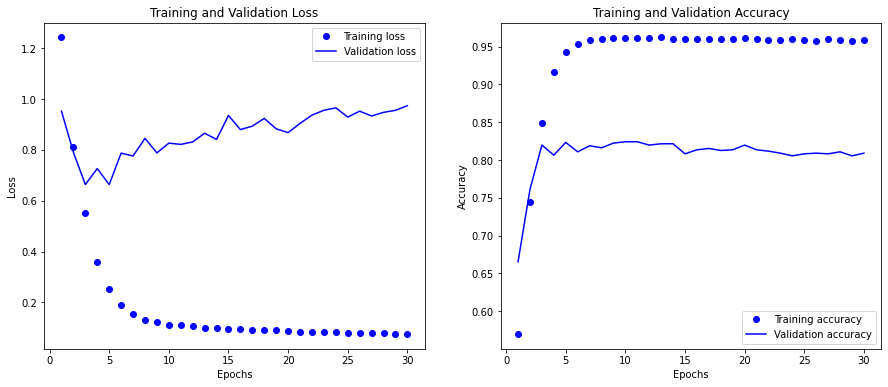

In [0]:
#model_1
plot_results(performance)

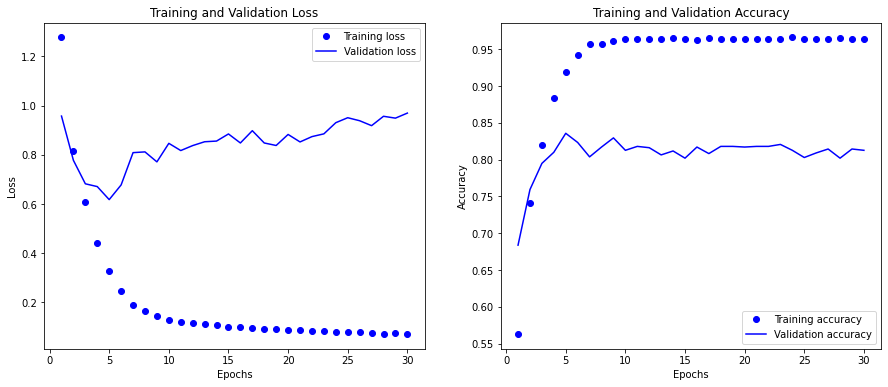

In [0]:
#model_2
plot_results(performance)

In [0]:
def plot_gradients(grads, layer):

    epochs = len(grads)
    prior_layer_num = sample(range(grads[0][layer].shape[0]),1)
    current_lay_num = range(grads[0][layer].shape[1])
    for current_layer in sample(current_lay_num,5):
        grad = []
        for epoch in range(epochs):
            value = grads[epoch][layer][prior_layer_num][current_layer].numpy()
            grad.append(value)

        plt.plot(grad)

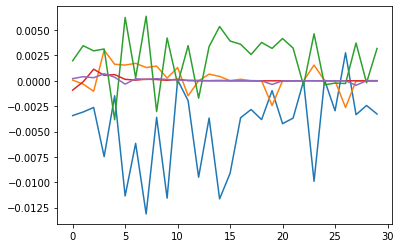

In [0]:
#Model 1
plot_gradients(grads, 3)

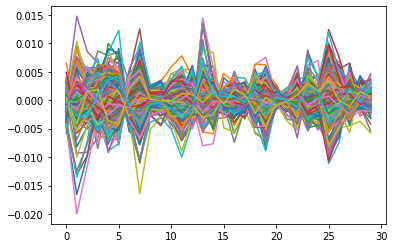

In [0]:
#Model 2
plot_gradients(grads, 3)

In [0]:
def return_final_parameters(model, X):
    
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = tf.keras.Model(inputs = model.input, outputs = layer_outputs)
    activations = activation_model.predict(X)

    weights = [layer.get_weights() for layer in model.layers]
    return activations, weights

In [0]:
def plot_weights(weight_history, layer, model):
    
    num_weights = np.shape(weight_history[0][layer][0])[0]
    num_neurons = np.shape(weight_history[0][layer][0])[1]
    epochs = len(weight_history)
    weights_to_plot = {}
    num_plots = 5
    fig, ax = plt.subplots(1, num_plots, figsize = [20, 6])
    for axes in range(num_plots):
        for weight in sample(list(np.arange(0, num_weights, 1)), 1):
            for neuron in list(np.arange(0, num_neurons, 1)):
                weight_id = f'N{neuron}_W{weight}'
                weights_to_plot[weight_id] = []
                for epoch in range(epochs-1):
                    weights_to_plot[weight_id].append(weight_history[epoch][layer][0][weight][neuron])
                ax[axes].plot(weights_to_plot[weight_id], label = weight_id)
                # ax[axes].legend()
                ax[axes].set_xlabel('Epoch')
                ax[axes].set_ylabel('Weight Value')
                ax[axes].set_title(f'Weight {weight} Per Neuron and Epoch')

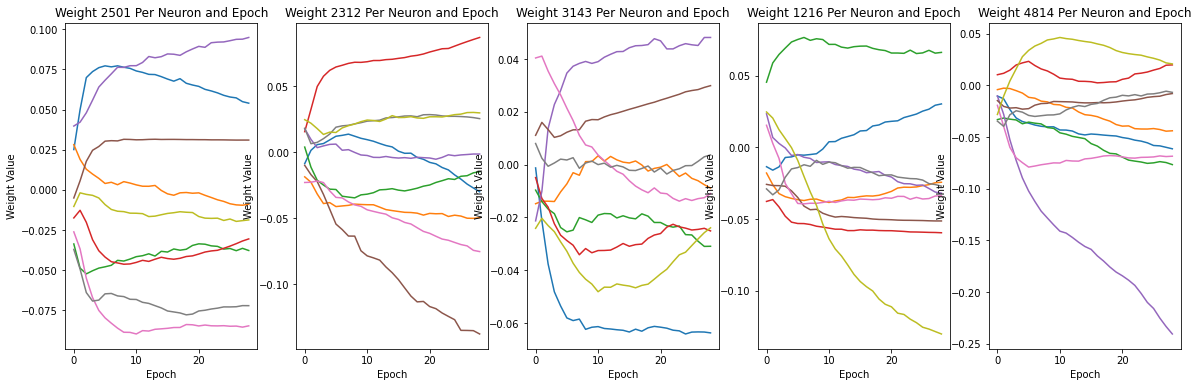

In [0]:
#Model 1
plot_weights(weight_history, 4, model_1)

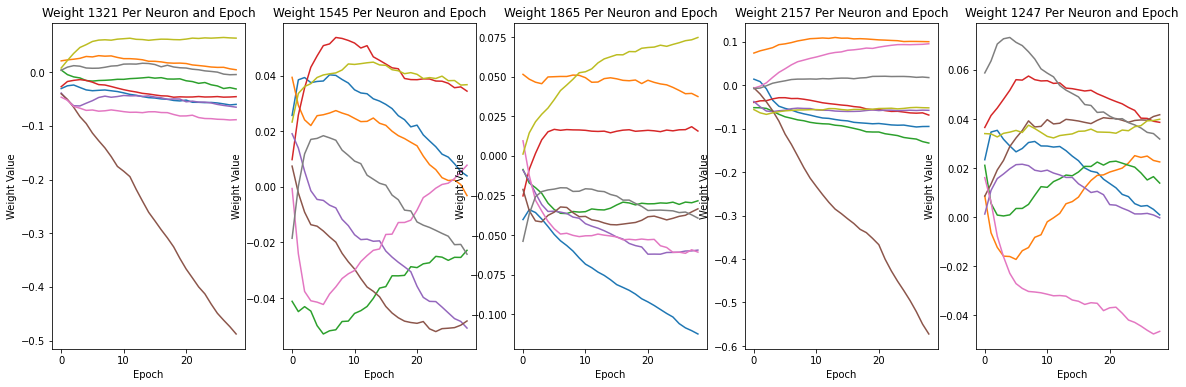

In [0]:
#Model 2
plot_weights(weight_history, 7, model_2)